# Homework 3 - TMDB Box Office Prediction

For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. Show runtime results for each cell. We also ask that code be commented to make it easier to follow.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd '/content/gdrive/My Drive/519/HW3'

/content/gdrive/My Drive/519/HW3


In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [4]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import copy
from collections import Counter
import datetime
from wordcloud import WordCloud
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

# Part 1 - Data Cleaning and Reformatting

In [5]:
# load data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [6]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


## 1. Reformating

Dict Columns:

In [7]:
reformat_columns = ['belongs_to_collection', 'genres', 'production_companies','production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

In [8]:
# transfer from string to list of dicts
def str_to_dict(x):
  if pd.isna(x):
    x = {0}
  else:
    x = ast.literal_eval(x)
  return x

In [9]:
for col in reformat_columns:
  train[col] = train[col].apply(str_to_dict)
  test[col] = test[col].apply(str_to_dict)
train[reformat_columns].head()

,belongs_to_collection,genres,production_companies,production_countries,spoken_languages,Keywords,cast,crew
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...","[{'id': 35, 'name': 'Comedy'}]","[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,"[{'id': 107674, 'name': 'The Princess Diaries ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,{0},"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,{0},"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",{0},"[{'iso_3166_1': 'IN', 'name': 'India'}]","[{'iso_639_1': 'en', 'name': 'English'}, {'iso...","[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,{0},"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",{0},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]","[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",{0},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de..."


In [10]:
# keep useful part from dict
string_space = 'name'

def extract_name(x):
  y=[]
  if x != {0}:
    for i in x:
      #print(i['name'])
      y.append(i[string_space])
    x=y
    #print(y)
  else:
    x = []
  return x

train['belongs_to_collection'] = train['belongs_to_collection'].apply(extract_name)
test['belongs_to_collection'] = test['belongs_to_collection'].apply(extract_name)

list_of_genres = train['genres'].apply(extract_name)
train['genres'] = train['genres'].apply(extract_name)
test['genres'] = test['genres'].apply(extract_name)

list_companies = train['production_companies'].apply(extract_name)
train['production_companies'] = train['production_companies'].apply(extract_name)
test['production_companies'] = test['production_companies'].apply(extract_name)

string_space = 'iso_3166_1'
list_of_countries = train['production_countries'].apply(extract_name)
train['production_countries'] = train['production_countries'].apply(extract_name)
test['production_countries'] = test['production_countries'].apply(extract_name)

string_space = 'iso_639_1'
list_of_spoken_lang = train['spoken_languages'].apply(extract_name)
train['spoken_languages'] = train['spoken_languages'].apply(extract_name)
test['spoken_languages'] = test['spoken_languages'].apply(extract_name)

string_space = 'name'
#train['cast_name'] = train['cast'].apply(extract_name)

list_keyword = train['Keywords'].apply(extract_name)
train['Keywords'] = train['Keywords'].apply(extract_name)
test['Keywords'] = test['Keywords'].apply(extract_name)


In [11]:
train[reformat_columns].head()

,belongs_to_collection,genres,production_companies,production_countries,spoken_languages,Keywords,cast,crew
0,[Hot Tub Time Machine Collection],[Comedy],"[Paramount Pictures, United Artists, Metro-Gol...",[US],[en],"[time travel, sequel, hot tub, duringcreditsst...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,[The Princess Diaries Collection],"[Comedy, Drama, Family, Romance]",[Walt Disney Pictures],[US],[en],"[coronation, duty, marriage, falling in love]","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,[],[Drama],"[Bold Films, Blumhouse Productions, Right of W...",[US],[en],"[jazz, obsession, conservatory, music teacher,...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,[],"[Thriller, Drama]",[],[IN],"[en, hi]","[mystery, bollywood, police corruption, crime,...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,[],"[Action, Thriller]",[],[KR],[ko],[],"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de..."


Realease Date:

In [12]:
train['release_date'] = pd.to_datetime(train['release_date'])

def fix_date(x):
    if x.year > 2017:
        year = x.year - 100
    else:
        year = x.year
    return datetime.date(year,x.month,x.day)

train['release_date'] = train['release_date'].apply(fix_date)

# insert year, month, weekday columns
train.insert(14,"year",pd.to_datetime(train["release_date"]).dt.strftime('%Y').astype(int))
train.insert(15,"month",pd.to_datetime(train["release_date"]).dt.strftime('%m').astype(int))
train.insert(16,"weekday",pd.to_datetime(train["release_date"]).dt.strftime('%A'))
train.insert(17,"day_of_week",pd.to_datetime(train["release_date"]).dt.strftime('%w').astype(int))

test.loc[test['release_date'].isna(),'release_date'] = '1/5/20'
test['release_date'] = pd.to_datetime(test['release_date'])
test['release_date'] = test['release_date'].apply(fix_date)

test.insert(14,"year",pd.to_datetime(test["release_date"]).dt.strftime('%Y').astype(int))
test.insert(15,"month",pd.to_datetime(test["release_date"]).dt.strftime('%m').astype(int))
test.insert(16,"weekday",pd.to_datetime(test["release_date"]).dt.strftime('%A'))
test.insert(17,"day_of_week",pd.to_datetime(test["release_date"]).dt.strftime('%w').astype(int))

train[['release_date']].head()

,release_date
0,2015-02-20
1,2004-08-06
2,2014-10-10
3,2012-03-09
4,2009-02-05


##2. Data Cleaning

**Runtime:**

In [13]:
train['runtime'].describe()

count    2998.000000
mean      107.856571
std        22.086434
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

In [14]:
#train runtime
runtime_na = train[train['runtime'].isna()][['id','title','runtime','release_date','imdb_id']]
runtime_zero = train.loc[train['runtime']==0,['id','title','runtime','release_date','imdb_id']]
runtime_anom = pd.concat([runtime_zero,runtime_na])
runtime_anom

,id,title,runtime,release_date,imdb_id
390,391,The Worst Christmas of My Life,0.0,2012-12-22,tt2550838
591,592,А поутру они проснулись,0.0,2003-12-04,tt0768690
924,925,¿Quién mató a Bambi?,0.0,2013-11-15,tt2604346
977,978,La peggior settimana della mia vita,0.0,2011-10-27,tt2076251
1255,1256,"Cry, Onion!",0.0,1975-08-25,tt0072785
1541,1542,All at Once,0.0,2014-06-05,tt3805180
1874,1875,Missing,0.0,2007-01-01,tt1133617
2150,2151,Mechenosets,0.0,2006-10-12,tt0477337
2498,2499,Hooked on the Game 2. The Next Level,0.0,2010-04-15,tt1620549
2645,2646,My Old Classmate,0.0,2014-04-25,tt3956312


In [15]:
# fill with accurate data

train.loc[train['id']==391,'runtime']= 86
train.loc[train['id']==592,'runtime']= 90
train.loc[train['id']==925,'runtime']= 86
train.loc[train['id']==978,'runtime']= 93
train.loc[train['id']==1256,'runtime']= 92
train.loc[train['id']==1542,'runtime']= 93
train.loc[train['id']==1875,'runtime']= 86
train.loc[train['id']==2151,'runtime']= 108
train.loc[train['id']==2499,'runtime']= 86
train.loc[train['id']==2646,'runtime']= 98
train.loc[train['id']==2786,'runtime']= 101
train.loc[train['id']==2866,'runtime']= 96
train.loc[train['id']==1336,'runtime']= 130
train.loc[train['id']==2303,'runtime']= 108

test.loc[test['id'] == 3244,'runtime'] = 93 
test.loc[test['id'] == 4490,'runtime'] = 90 
test.loc[test['id'] == 4633,'runtime'] = 108 
test.loc[test['id'] == 6818,'runtime'] = 90 
test.loc[test['id'] == 4074,'runtime'] = 103 
test.loc[test['id'] == 4222,'runtime'] = 91 
test.loc[test['id'] == 4431,'runtime'] = 96
test.loc[test['id'] == 5520,'runtime'] = 86
test.loc[test['id'] == 5845,'runtime'] = 83 
test.loc[test['id'] == 5849,'runtime'] = 140 
test.loc[test['id'] == 6210,'runtime'] = 104
test.loc[test['id'] == 6804,'runtime'] = 140 
test.loc[test['id'] == 7321,'runtime'] = 87 

In [16]:
train['runtime'].describe()

count    3000.000000
mean      108.235667
std        21.024433
min        11.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

**Budget:**

In [17]:
train['budget'].describe()

count    3.000000e+03
mean     2.253133e+07
std      3.702609e+07
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+06
75%      2.900000e+07
max      3.800000e+08
Name: budget, dtype: float64

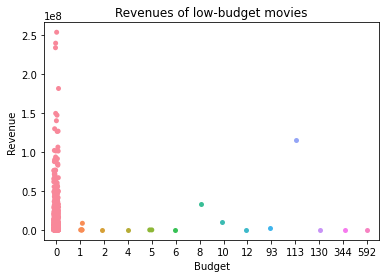

In [18]:
low_budget = train[train["budget"] <= 1000]

sns.stripplot(x='budget', y='revenue', data = low_budget, jitter=True)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Revenues of low-budget movies')
plt.show()

In [19]:
low_budget[low_budget["revenue"] >= 100000000][['id','budget','original_title','year','imdb_id','revenue']]

,id,budget,original_title,year,imdb_id,revenue
89,90,0,Sommersby,1993,tt0108185,140081992
104,105,0,Recep İvedik 4,2014,tt3477064,149521495
117,118,0,Wild Hogs,2007,tt0486946,253625427
148,149,0,Beethoven,1992,tt0103786,147214049
463,464,0,Parenthood,1989,tt0098067,126297830
469,470,113,"The Karate Kid, Part II",1986,tt0091326,115103979
818,819,0,Alvin and the Chipmunks: The Road Chip,2015,tt2974918,233755553
1111,1112,0,An Officer and a Gentleman,1982,tt0084434,129795554
1130,1131,0,Smokey and the Bandit,1977,tt0076729,126737428
1358,1359,0,Stir Crazy,1980,tt0081562,101300000


In [20]:
# fill those have the most difference (budget <= 1000 & revenue>100000000)

train.loc[train.id == 90,'budget'] = 30000000
train.loc[train.id == 118,'budget'] = 60000000
train.loc[train.id == 149,'budget'] = 18000000
train.loc[train.id == 464,'budget'] = 20000000
train.loc[train.id==470,'budget'] = 13000000
train.loc[train.id == 819,'budget'] = 90000000
train.loc[train.id == 1112,'budget'] = 6000000
train.loc[train.id == 1131,'budget'] = 4300000
train.loc[train.id == 1359,'budget'] = 10000000
train.loc[train.id == 1570,'budget'] = 15800000
train.loc[train.id == 1714,'budget'] = 46000000
train.loc[train.id == 1865,'budget'] = 80000000
train.loc[train.id == 2602,'budget'] = 31000000

train.loc[train.id == 850,'budget'] = 1500000  # Modern Times
train.loc[train.id == 2256,'budget'] = 1500000  # Lost & Found
train.loc[train.id == 335,'budget'] = 1848922 #Saamy

# na values
train.loc[train['id']==334,'budget'] = 1820717
train.loc[train['id']==645,'budget'] = 1810798
train.loc[train['id']==1668,'budget'] = 1820717
train.loc[train['id']==2324,'budget'] = 403251


In [21]:
# for test budget, fix the wrong scale
low_budget_test = test[test["budget"] <= 1000]
for index, row in low_budget_test.iterrows():
  if row['budget'] < 100:
    test.loc[test.index==index,'budget'] = test.loc[test.index==index,'budget'] * 1000000
  elif row['budget'] < 1000:
    test.loc[test.index==index,'budget'] = row['budget'] * 1000

## for 0 values, fill zero value with mean budget per year
year_list = train['year'].unique()

#train budget
for year in year_list:
    year_mean = train[(train['year']==year) & (train['budget']!=0)]['budget'].mean()
    if year_mean != np.nan:
      train[train["year"]==year] = train[train["year"]==year].replace({"budget": 0}, year_mean)
#test budget
for year in year_list:
    year_mean = test[(test['year']==year) & (test['budget']!=0)]['budget'].mean()
    if year_mean != np.nan:
      test[test["year"]==year] = test[test["year"]==year].replace({"budget": 0}, year_mean)

In [22]:
# for the rest small budgets
low_budget = train[(train["budget"] <= 100) & (train["revenue"] > 100)][['id','budget','original_title','year','imdb_id','revenue']]
low_budget

,id,budget,original_title,year,imdb_id,revenue
512,513,93.0,From Prada to Nada,2011,tt0893412,2500000
796,797,8.0,웰컴 투 동막골,2005,tt0475783,33579813
1800,1801,5.0,The Cherry Orchard,1999,tt0144134,135
2695,2696,10.0,Nurse 3-D,2013,tt1913166,10000000


In [23]:
train.loc[train['id']==513,'budget'] = 1100000 # From Prada to Nada
train.loc[train['id']==797,'budget'] = 8000000 # 웰컴 투 동막골
train.loc[train['id']==2696,'budget'] = 10000000 # Nurse 3-D
train.loc[train.index==1800,'budget'] = 5000000 # The Cherry Orchard

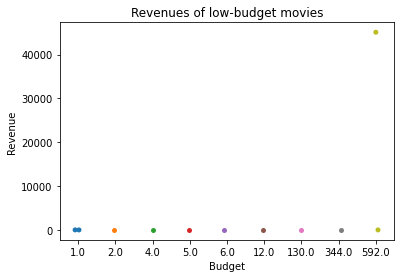

In [24]:
low_budget = train[train["budget"] <= 1000]
sns.stripplot(x='budget', y='revenue', data = low_budget, jitter=True)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Revenues of low-budget movies')
plt.show()

Most budget with anomalies are fixed.

In [25]:
train[train["budget"] <= 100][['id','budget','original_title','year','imdb_id','revenue']]

,id,budget,original_title,year,imdb_id,revenue
347,348,12.0,The Wind in the Willows,1996,tt0118172,1
639,640,6.0,Pollock,2000,tt0183659,8
695,696,1.0,Tere Naam,2003,tt0374271,2
1198,1199,5.0,Every Which Way But Loose,1978,tt0077523,85
1346,1347,1.0,East of Eden,1955,tt0048028,5
1754,1755,2.0,Mute Witness,1995,tt0110604,1
2032,2033,4.0,A Farewell to Arms,1932,tt0022879,25


These low-budget data might have some scaling problems, so they could be dealt with revenue together.

**Revenue:**

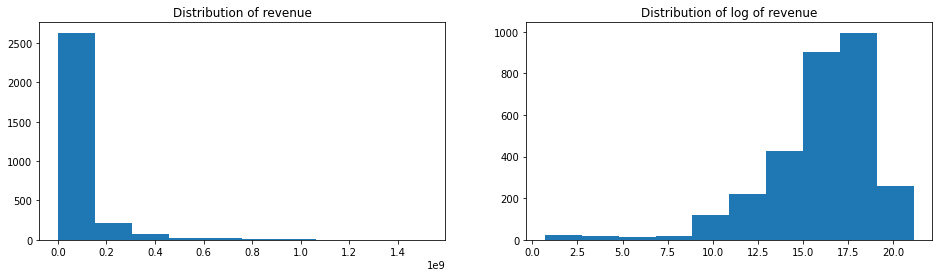

In [26]:
fig, ax = plt.subplots(figsize = (16, 4))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

In [27]:
# fix the revenue with wrong scale
low_revenue = train.loc[train['revenue']<100,['budget','original_title','imdb_id','year','revenue']]

fix_idx = [150,280,450,1138,1198,1281,1884,2399,2433,2474]
for index, row in low_revenue.iterrows():
  if index in fix_idx:
    train.loc[train.index==index,'revenue'] = train.loc[train.index==index,'revenue'] * 1000
    if row['budget'] < 10:
      train.loc[train.index==index,'budget'] = row['budget'] * 1000
  elif row['revenue'] < 10:
    train.loc[train.index==index,'revenue'] = row['revenue'] * 1000000
    if row['budget'] < 20:
      train.loc[train.index==index,'budget'] = row['budget'] * 1000000
  else:
    train.loc[train.index==index,'revenue'] = row['revenue'] * 1000
    if row['budget'] < 1000:
      train.loc[train.index==index,'budget'] = row['budget'] * 1000

# revenue that not following the rules
train.loc[train.index==579,'revenue'] = 2400000 #Blood on the moon
train.loc[train.index==1006,'revenue'] = 30 # Zyzzyx Road
train.loc[train.index==1346,'revenue'] = 24079 # East of Eden
train.loc[train.index==2117,'revenue'] = 344992 # American Adobo
train.loc[train.index==2759,'revenue'] = 1694899 # Dou Sing2

In [28]:
# revenue with 3 digits
medium_revenue = train.loc[((train['revenue']>=100) & (train['revenue']<=1000)),['budget','original_title','imdb_id','year','revenue']]

for index, row in medium_revenue.iterrows():
  train.loc[train.index==index,'revenue'] = row['revenue'] * 1000

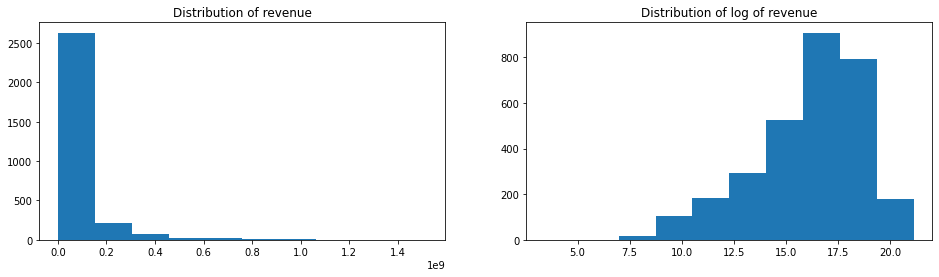

In [29]:
fig, ax = plt.subplots(figsize = (16, 4))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

The distribution of log_revenue is no longer as skewed as before.

# Part 2 - Word Cloud

In [30]:
list_all_genres = []
for x in list_of_genres:
  for i in range(len(x)):
    list_all_genres.append(x[i])
list_all_genres[:5]

['Comedy', 'Comedy', 'Drama', 'Family', 'Romance']

In [31]:
genres_values, genres_counts = np.unique(list_all_genres, return_counts=True)
wordcloud_genres = Counter(list_all_genres)
wordcloud_genres.most_common(4)

[('Drama', 1531), ('Comedy', 1028), ('Thriller', 789), ('Action', 741)]

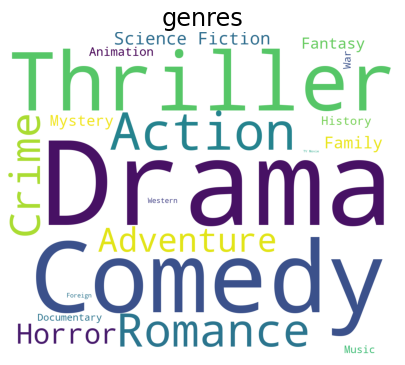

In [32]:
plt.figure(figsize=(18,6))
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,width=1200, height=1000).generate_from_frequencies(wordcloud_genres)
plt.imshow(wordcloud)
plt.title('genres',size=24)
plt.axis("off")
plt.show()

In [33]:
list_all_keyword = []
for x in list_keyword:
  for i in range(len(x)):
    list_all_keyword.append(x[i])
list_all_keyword[:5]

['time travel', 'sequel', 'hot tub', 'duringcreditsstinger', 'coronation']

In [34]:
wordcloud_keywords = Counter(list_all_keyword)
wordcloud_keywords.most_common(4)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123)]

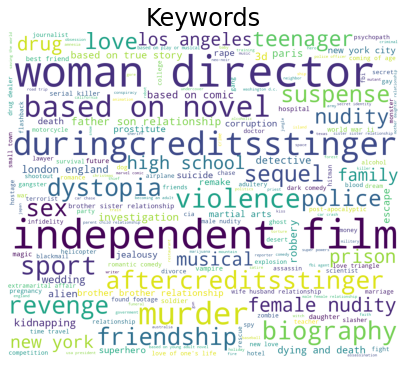

In [35]:
plt.figure(figsize=(18,6))
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,width=1200, height=1000).generate_from_frequencies(wordcloud_keywords)
plt.imshow(wordcloud)
plt.title('Keywords',size=24)
plt.axis("off")
plt.show()

In [36]:
list_all_original_titles = []
for x in train['original_title']:
  list_all_original_titles.append(x)
list_all_original_titles[:3]

['Hot Tub Time Machine 2',
 'The Princess Diaries 2: Royal Engagement',
 'Whiplash']

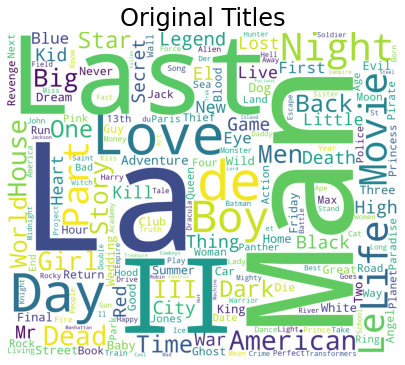

In [37]:
wordcloud_orig_title = ' '.join(list_all_original_titles)

plt.figure(figsize=(18,6))
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,width=1200, height=1000).generate(wordcloud_orig_title)
plt.imshow(wordcloud)
plt.title('Original Titles',size=24)
plt.axis("off")
plt.show()

In [38]:
list_all_overview = []
for x in train['overview']:
  if (type(x)==str):
    list_all_overview.append(x)
list_all_overview[:3]

['When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.',
 "Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as princess. Her best friend Lilly also joins her for the summer. Mia continues her 'princess lessons'- riding horses side-saddle, archery, and other royal. But her complicated life is turned upside down once again when she not only learns that she is to take the crown as queen earlier than expected...",
 'Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfection at any cost, even his humanity.']

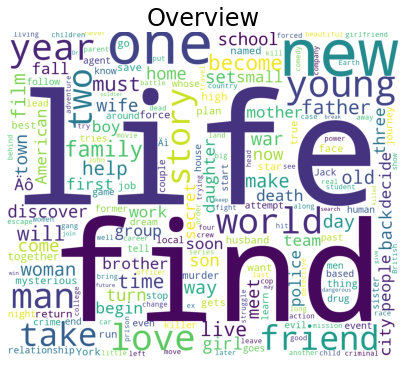

In [39]:
wordcloud_overview = ' '.join(list_all_overview)

plt.figure(figsize=(18,6))
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,width=1200, height=1000).generate(wordcloud_overview)
plt.imshow(wordcloud)
plt.title('Overview',size=24)
plt.axis("off")
plt.show()

# Part 3 - Time Series Analysis

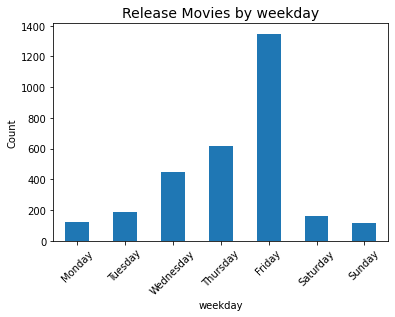

In [40]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mons = [ '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

train.groupby('weekday')['imdb_id'].count().reindex(days).plot(kind='bar')

plt.title("Release Movies by weekday", size=14)
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

Most of the movies released on Friday, so that people can go to see the movies on weekends.

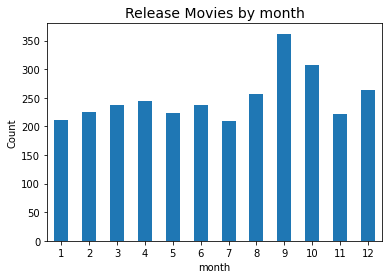

In [41]:
train.groupby('month')['imdb_id'].count().plot(kind='bar')
plt.title("Release Movies by month", size=14)
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

September and October has the most released movie number. In other months there isn't an obvious trending.

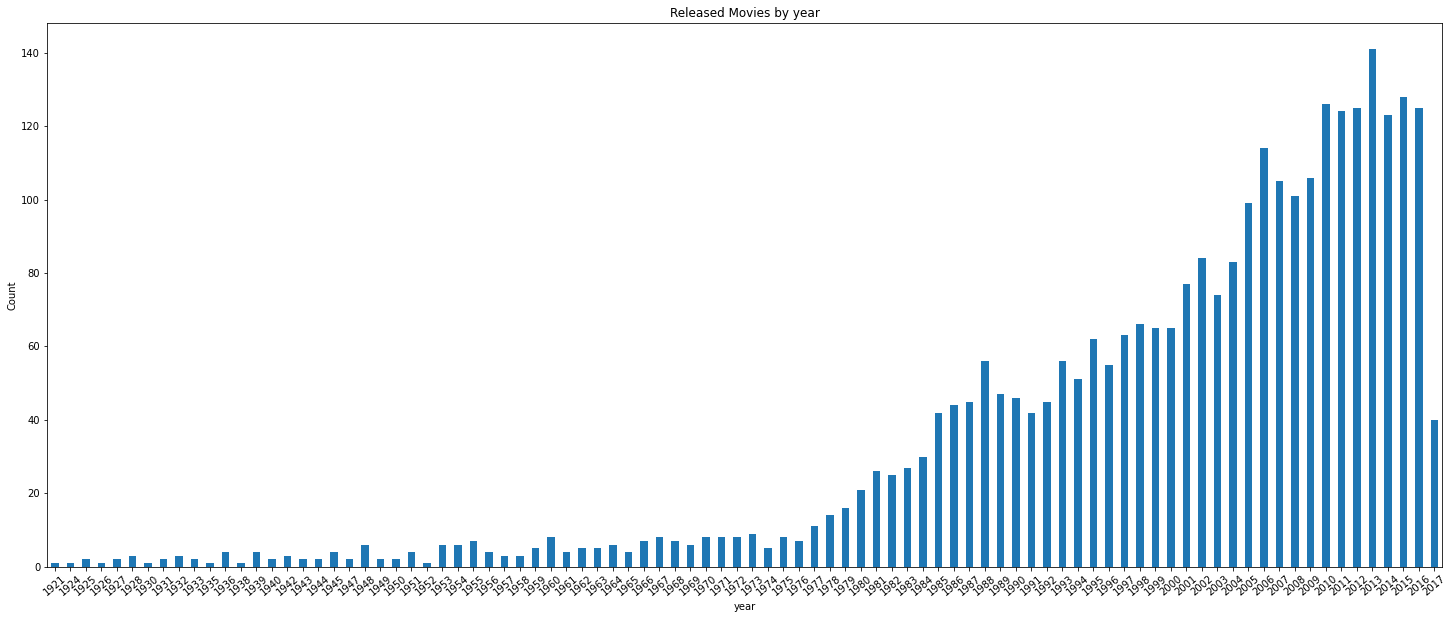

In [42]:
year_list.tolist()
year_list.sort()

plt.figure(figsize=(25,10))
train.groupby('year')['imdb_id'].count().reindex(year_list).plot(kind='bar')
plt.title("Released Movies by year", size=12)
plt.xticks(rotation = 40)
plt.ylabel('Count')
plt.show()

Starting from the late 70's, the number of released films has a  tremendous growth, indicating there is a big market in this area.<br> In 2017 there are not many records, leading a huge decreasing.

# Part 4 - Cast Power

In [43]:
# extract the cast name
train['cast_name'] = train['cast'].apply(extract_name)
test['cast_name'] = test['cast'].apply(extract_name)
train[['cast_name']].head()

,cast_name
0,"[Rob Corddry, Craig Robinson, Clark Duke, Adam..."
1,"[Anne Hathaway, Julie Andrews, H√©ctor Elizond..."
2,"[Miles Teller, J.K. Simmons, Melissa Benoist, ..."
3,"[Vidya Balan, Nawazuddin Siddiqui, Parambrata ..."
4,"[Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim..."


1) Actor Power Score (APS)<br/>
Compute each actor’s ‘Actor
Power Score (APS)’ by counting the number of times this actor
appears in the dataset. 

In [44]:
# split the cast list
list_all_cast = []
for x in train['cast_name']:
  for i  in x:
    list_all_cast.append(i)
list_all_cast[:5]

# count the occurence
cast_values, cast_counts = np.unique(list_all_cast, return_counts=True)
cast_count_pair = list(zip(cast_values,cast_counts))
cast_count_pair.sort(key = lambda x: x[1],reverse=True)
cast_count_pair[:10]

[('Robert De Niro', 30),
 ('Samuel L. Jackson', 30),
 ('Morgan Freeman', 27),
 ('Bruce Willis', 25),
 ('J.K. Simmons', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23)]

2) Average Actor Star-power (AvAS)  = Total Actor Star-power (TAS)  / Number of Actors(NAct)<br> For each movie the dataset, add the power scores of all the actors in the movie to compute the ‘Total Actor Star-power (TAS)’ of it.<br>Then divide this by the number of actors (NAct) in the movie to
calculate the ‘Average Actor Star-power (AvAS)’.

In [45]:
# Total Actor Star-power (TAS)
cast_pair_dict = dict(cast_count_pair)

def actor_power_count(x):
  score = 0
  for i in x:
    if i in cast_pair_dict.keys():
      score += cast_pair_dict[i]
  return score

In [46]:
def cast_power(df):
  # total cast power
  df['total_cast_power'] = df['cast_name'].apply(actor_power_count)
  
  #cast count
  df['cast_count'] = df['cast_name'].apply(lambda x: len(x) if x != {0} else 0)

  # cast power = total_cast_power / cast_count
  df['cast_power'] = df['total_cast_power'] / df['cast_count']
  df['cast_power'] = df['cast_power'].fillna(df['cast_power'].mean())

  #normalization
  df['norm_cast_power'] = df['cast_power'].apply(lambda x: (x - df['cast_power'].min() ) / ( df['cast_power'].max()-df['cast_power'].min()))

  df['log_cast_power'] = np.log1p(df['cast_power'])
  df['log_budget'] = np.log1p(df['budget'])
  if 'revenue' in df.columns.values:
    df['log_revenue'] = np.log1p(df['revenue'])

  return df

train = cast_power(train)
test = cast_power(test)
train[['total_cast_power','cast_count','cast_power','norm_cast_power']].head()

,total_cast_power,cast_count,cast_power,norm_cast_power
0,101,24,4.208333,0.110632
1,95,20,4.750000,0.129310
2,108,51,2.117647,0.038540
3,11,7,1.571429,0.019704
4,5,4,1.250000,0.008621


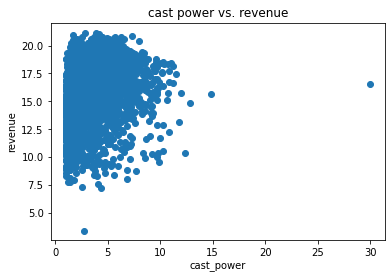

In [47]:
plt.scatter(train['cast_power'],train['log_revenue'])
plt.title('cast power vs. revenue');
plt.xlabel('cast_power')
plt.ylabel('revenue')
plt.show()

In [52]:
diff = train[['cast_power','total_cast_power','log_cast_power','revenue','log_revenue']]
corr = diff.corr(method="pearson")
corr[['cast_power','total_cast_power','log_cast_power']]

,cast_power,total_cast_power,log_cast_power
cast_power,1.000000,0.388451,0.960536
total_cast_power,0.388451,1.000000,0.448426
log_cast_power,0.960536,0.448426,1.000000
revenue,0.110561,0.449507,0.149522
log_revenue,0.214146,0.481159,0.277080


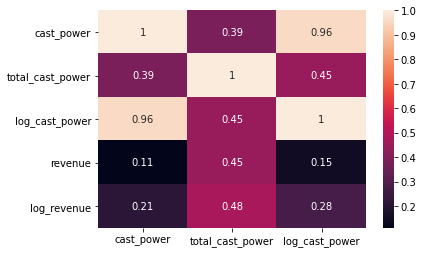

In [56]:
sns.heatmap(corr[['cast_power','total_cast_power','log_cast_power']], annot=True)
plt.show()

***Cast power*** does show some relation with revenue, and ***Total Cast Power*** shows a higher value, but not as high as other features like budgets. <br>

# Part 5 - External Dataset

In [57]:
print("train shape before: ",train.shape)

train_add = pd.read_csv('TrainAdditionalFeatures.csv')
test_add = pd.read_csv('TestAdditionalFeatures.csv')

train = pd.merge(train, train_add, how='left', on=['imdb_id'])
test = pd.merge(test, test_add, how='left', on=['imdb_id'])

print("train shape after: ",train.shape)

train shape before:  (3000, 35)
train shape after:  (3000, 38)


In [58]:
train.columns.shape,test.columns.shape

((38,), (36,))

In [59]:
train['rating'] = train['rating'].fillna(1.5)
train['totalVotes'] = train['totalVotes'].fillna(6)

test['rating'] = test['rating'].fillna(1.5)
test['totalVotes'] = test['totalVotes'].fillna(6)

train['popularity2'] = train['popularity2'].fillna(train.groupby(['original_language','year'])['popularity2'].transform('mean'))
test['popularity2'] = test['popularity2'].fillna(test.groupby(['original_language','year'])['popularity2'].transform('mean'))

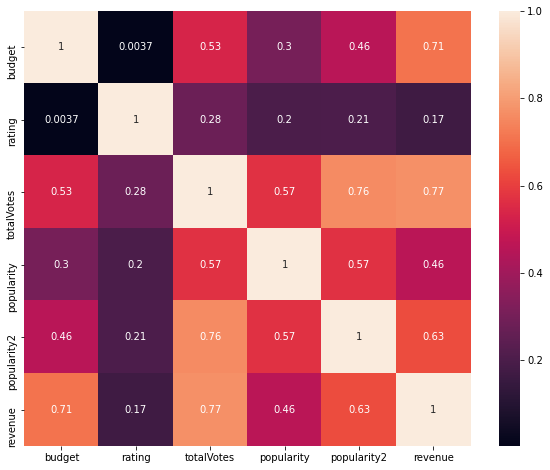

In [60]:
corr_matrix = train[['budget','rating','totalVotes','popularity','popularity2','revenue']]
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix.corr(), annot=True)
plt.show()

###Analysis:
Data set source: https://www.kaggle.com/kamalchhirang/tmdb-competition-additional-features <br/>
What information it contains: This data set contains the rating, total votes and popularity. <br/>From the corrlation heatmap, ***total votes*** and  ***popularity2*** have a high correlation with revenue, so it would be helpful to use it in later analysis.


# Part 6 - Informative Plots

### Plot 1: Revenue by year

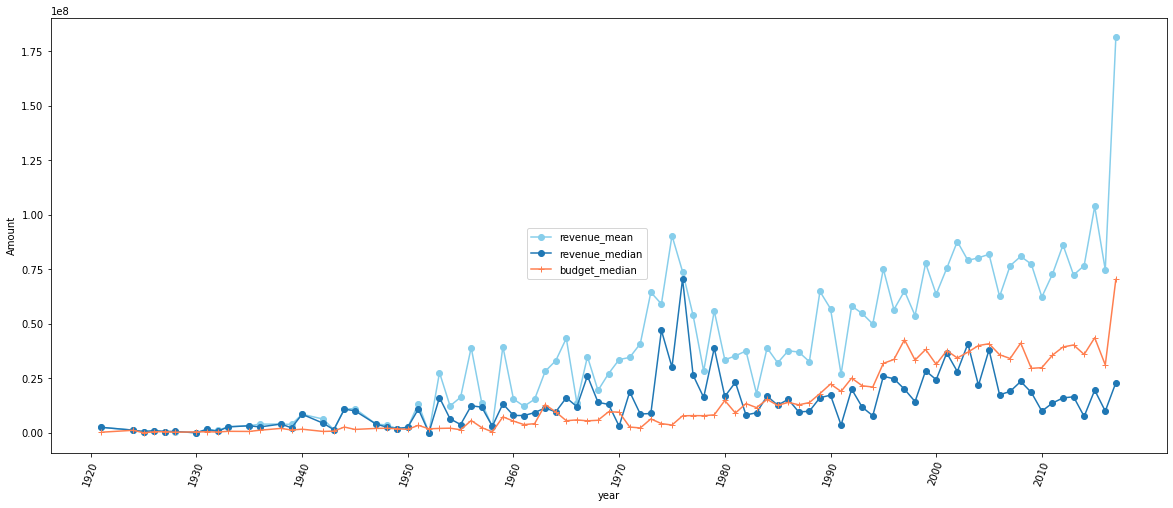

In [61]:
#fig,ax=plt.subplots()
plt.figure(figsize=(20,8))
ax = train.groupby('year')['revenue'].mean().reindex(year_list.sort()).plot( color='skyblue',marker = 'o',label='revenue_mean')
ax.set_ylabel("Amount")
ax = train.groupby('year')['revenue'].median().reindex(year_list.sort()).plot(marker = 'o',label='revenue_median')
ax = train.groupby('year')['budget'].mean().reindex(year_list.sort()).plot(color='coral',marker = '+',label='budget_median')
ax.figure.legend(loc='center')
plt.xticks(np.arange(1920,2018,10), rotation=70,size=10)
plt.show()

1. Revenue Info: <br/>The mean revenue has increasing a lot during these years. However, the  median revenue does not increase much all the time. The mean value could be effected by the extrem high revenue, thus median may be a better indicator of the revenue change.<br/>Both the mean and median revenue have an obious peak in the 70s, indicating that there is indeed a popularity at that time.<br/>
2. Budget and Revenue: <br/>From the median budget and revenue we can see that, the budget over the years is increasing, but the revenue does not increase accordingly. Thus although the numbers of released movies grows a lot, the film industry may not make much profit these years.

### Plot2: How the genres effect revenue

In [62]:
# create a genres dict to store number of movies in each genre.
genres_dict = dict()

for genre in train["genres"]:
    for elem in genre:
        if elem not in genres_dict:
            genres_dict[elem] = 1
            #print('1',elem)
        else:
            genres_dict[elem] += 1
            #print('2',elem)

In [63]:
genres_df = pd.DataFrame.from_dict(genres_dict, orient='index')
genres_df.columns = ["count_of_genres"]
genres_df = genres_df.sort_values(by="count_of_genres", ascending=False)
genres_df.head()

,count_of_genres
Drama,1531
Comedy,1028
Thriller,789
Action,741
Romance,571


In [64]:
genres_split = pd.DataFrame()
genres_values, genres_counts = np.unique(list_all_genres, return_counts=True)

for g in genres_values:
    genres_split['genres_' + g] = train['genres'].apply(lambda x: 1 if g in x else 0)

for index, genres in enumerate(genres_df.index.values):
    genres_df.loc[genres, "median_revenue"] = train[genres_split['genres_' + genres]==1].revenue.median()

genres_df.sort_values(by=["count_of_genres", "median_revenue"], ascending=False)
genres_df.drop('TV Movie',inplace=True)
genres_df.head()

,count_of_genres,median_revenue
Drama,1531,11293663.0
Comedy,1028,18809184.0
Thriller,789,21890845.0
Action,741,36000000.0
Romance,571,14016568.0


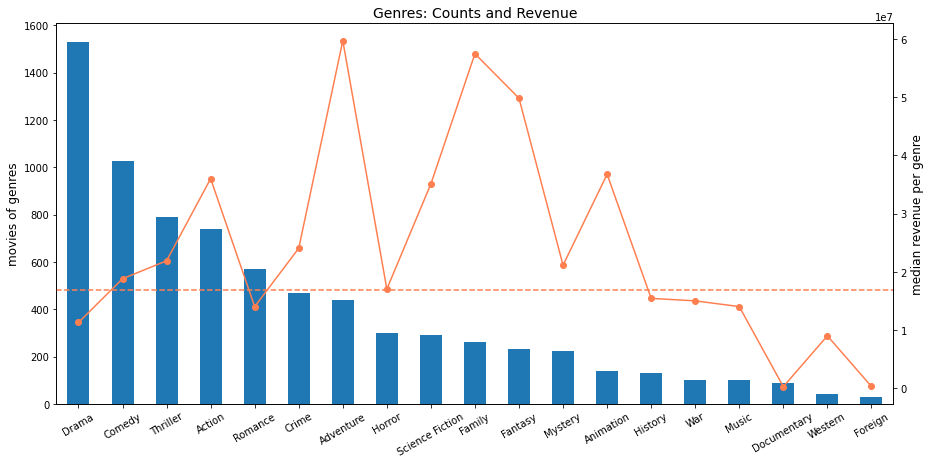

In [65]:
plt.figure(figsize=(15,7))
ax1 = genres_df['count_of_genres'].plot(kind='bar')
ax2 = genres_df['median_revenue'].plot(secondary_y=True, marker = 'o',color='coral')

ax2.set_title("Genres: Counts and Revenue", size=14)
ax1.set_ylabel("movies of genres",size=12)
ax2.set_ylabel('median revenue per genre',size=12)
for label in ax1.get_xticklabels():
    label.set_ha("center")
    label.set_rotation(30)

ax2.axhline(train['revenue'].median(),color='coral',linestyle='--')
plt.show()

From the plot, ***Drama, Comdedy, Thriller*** are the top 3 genres that have the most numbers. <br/>However, they are not the ones that make the most revenue. Instead, the revenue shows an opposite trend. <br>Thus, just making movies of the top genres may not guarantee profits.

### Plot 3: Production Companies with Revenue

In [66]:
# create a genres dict to store number of movies in each genre.
company_dict = dict()

for comp in train["production_companies"]:
    for elem in comp:
        if elem not in company_dict:
            company_dict[elem] = 1
            #print('1',elem)
        else:
            company_dict[elem] += 1
            #print('2',elem)
comp_df = pd.DataFrame.from_dict(company_dict, orient='index')
comp_df.columns = ["count_of_movies"]
comp_df = comp_df.sort_values(by="count_of_movies", ascending=False)

In [67]:
list_all_companies = []
for x in list_companies:
  for i in range(len(x)):
    list_all_companies.append(x[i])

company_values, company_counts = np.unique(list_all_companies, return_counts=True)
company_count_pair = list(zip(company_values,company_counts))
company_count_pair.sort(key = lambda x: x[1],reverse=True)

top10_companies = []
for p in company_count_pair[:10]:
  top10_companies.append(p[0])

In [68]:
comp_split = pd.DataFrame()
comp_values, comp_counts = np.unique(list_all_companies, return_counts=True)

for g in top10_companies:
    comp_split['comp_' + g] = train['production_companies'].apply(lambda x: 1 if g in x else 0)


for index, company in enumerate(comp_df.head(10).index.values):
   comp_df.loc[company, "median_revenue"] = train[comp_split['comp_' + company]==1].revenue.median()
   #comp_df.loc[company, "mean_budget"] = train[comp_split['comp_' + company]==1].budget.mean()
   #comp_df.loc[company, "mean_popularity"] = train[comp_split['comp_' + company]==1].popularity.mean()

comp_df.sort_values(by=["count_of_movies"], ascending=False)
comp_df = comp_df.head(10)
comp_df

,count_of_movies,median_revenue
Warner Bros.,202,55653705.5
Universal Pictures,188,59540581.5
Paramount Pictures,161,52034889.0
Twentieth Century Fox Film Corporation,138,50589532.0
Columbia Pictures,91,77737889.0
Metro-Goldwyn-Mayer (MGM),84,13220811.0
New Line Cinema,75,60740827.0
Touchstone Pictures,63,34808403.0
Walt Disney Pictures,62,160440216.0
Columbia Pictures Corporation,61,58853106.0


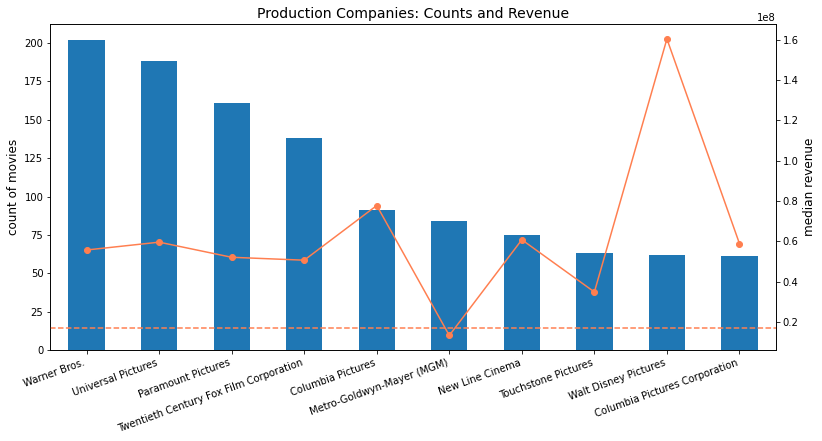

In [69]:
plt.figure(figsize=(13,6))
ax1 = comp_df['count_of_movies'].plot(kind='bar')
ax2 = comp_df['median_revenue'].plot(secondary_y=True, marker = 'o',color='coral')
#ax3 = comp_df['mean_budget'].plot(secondary_y=True, marker = 'o',color='r')

ax2.set_title("Production Companies: Counts and Revenue", size=14)
ax1.set_ylabel("count of movies",size=12)
ax2.set_ylabel('median revenue',size=12)
for label in ax1.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(20)
ax2.axhline(train['revenue'].median(),color = 'coral',linestyle='--')
plt.show()

 ***Warner Bros, Universal Pictures, Paramount Pictures*** are the top 3 companies that make the most movies. <br/>Almost all top10 companies make revenue far more than the average, except ***Metro-Goldwyn-Mayer***.<br>***Walt Disney Pictures*** makes the highest revenue among all top10 companies, which is around 8 times more than the average revenue.

### Plot4: Other features and their relations with revenue

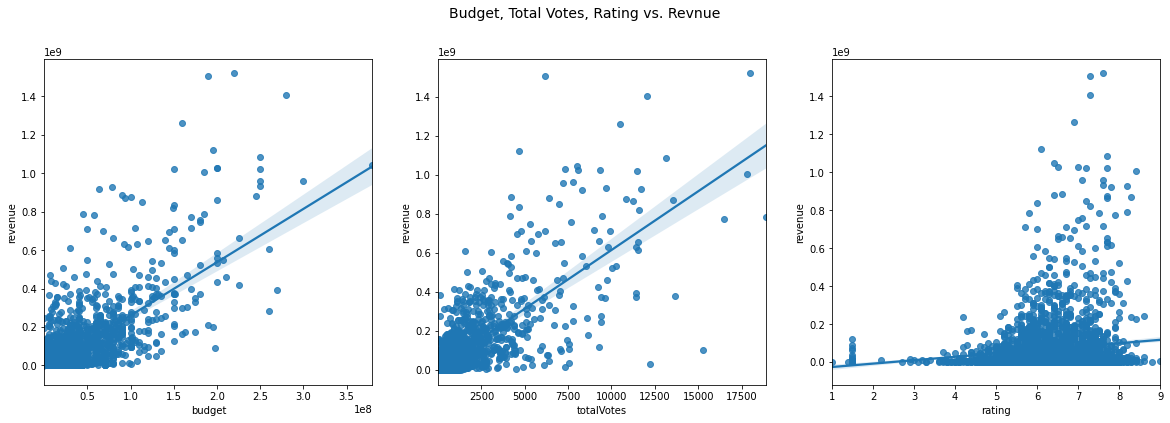

In [70]:
fig, axs = plt.subplots(1,3,figsize=(20,6))

sns.regplot(x=train["budget"],y=train["revenue"],ax=axs[0])

sns.regplot(x=train["totalVotes"],y=train["revenue"],ax=axs[1])

sns.regplot(x=train["rating"],y=train["revenue"],ax=axs[2])

fig.suptitle('Budget, Total Votes, Rating vs. Revnue', position=(.5,1), fontsize=14)
plt.show()

From the plots we can see that, ***budget*** and ***total votes*** show a higher relation with revenue, while ***rating*** shows a much weaker relation. <br>Thus a good movie may not represent a high revenue.

### Plot 5: Binary features and revenue

In [72]:
#binary features
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {0} else 0)
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
train['has_tagline'] = 0
train.loc[train['tagline'].isnull() == False, 'has_tagline'] = 1

test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {0} else 0)
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_tagline'] = 0
test.loc[test['tagline'].isnull() == False, 'has_tagline'] = 1

train["is_orig_eng"] = train['original_language'].apply(lambda x: 1 if x == "en" else 0)
test["is_orig_eng"] = test['original_language'].apply(lambda x: 1 if x == "en" else 0)

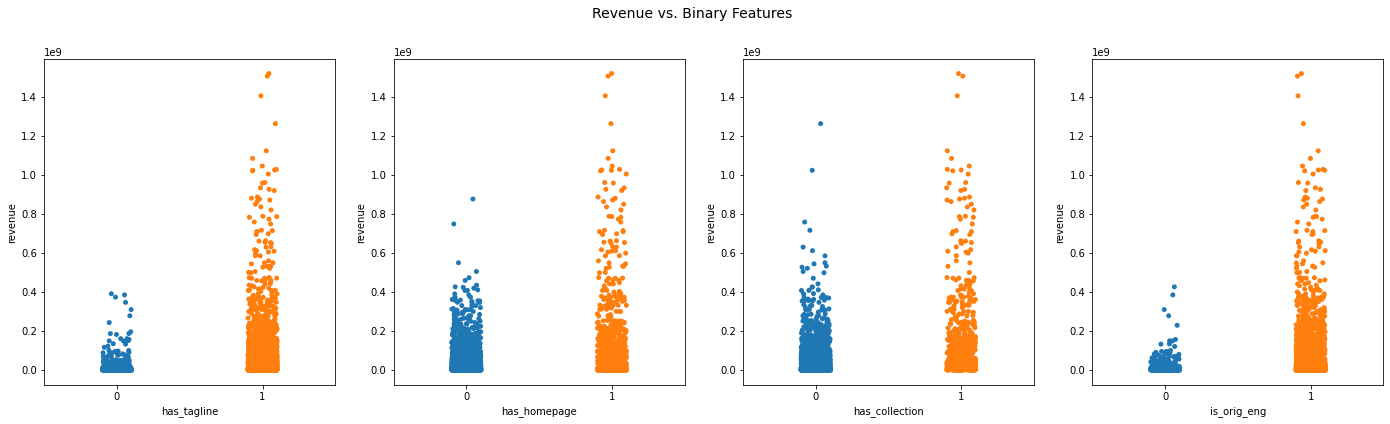

In [73]:
fig, axs = plt.subplots(1,4,figsize=(24,6))

sns.stripplot(x="has_tagline", y="revenue", data=train,ax=axs[0])
sns.stripplot(x="has_homepage", y="revenue", data=train,ax=axs[1])
sns.stripplot(x="has_collection", y="revenue", data=train,ax=axs[2])
sns.stripplot(x="is_orig_eng", y="revenue", data=train,ax=axs[3])

fig.suptitle('Revenue vs. Binary Features', position=(.5,1), fontsize=14)
plt.show()

From the binary features plot we can see that, English movies or those have the tagline and homepage will make a lot more revenue. <br/>As for the collection, if a movie has a collection, it will also make more revenue, but not as much as the other flag features. <br/>
In brief, the prferrable properties of a movie are: <br>1) having a tagline or a homepage, <br>2) English as the original language, <br>3) being in  a collection.

# Part 7 - Pairwise Pearson Correlation

In [74]:
def gender_count(x,code):
  gender_sum=0
  #print(type(i['gender']))
  for i in x:
    try:
      if(i['gender'] == code):
        gender_sum +=1
    except:
      gender_sum+=0
  return gender_sum

for i in range(3):
  train['num_gender'+str(i)+"_cast"] = train['cast'].apply(lambda x: gender_count(x,i))
  train['num_gender'+str(i)+"_crew"] = train['crew'].apply(lambda x: gender_count(x,i))
  test['num_gender'+str(i)+"_cast"] = test['cast'].apply(lambda x: gender_count(x,i))
  test['num_gender'+str(i)+"_crew"] = test['crew'].apply(lambda x: gender_count(x,i))


In [75]:
## new features

train['crew_name'] = train['crew'].apply(extract_name)
test['crew_name'] = test['crew'].apply(extract_name)

num_columns = ['genres','production_companies','production_countries','spoken_languages','Keywords','cast_name','crew_name']
for col in num_columns:
  train['num_'+ col] = train[col].apply(lambda x: len(x) if x != {0} else 0)
  test['num_'+ col] = test[col].apply(lambda x: len(x) if x != {0} else 0)

len_columns = ['tagline','overview','title']
for col in len_columns:
  train['len_'+ col] = train[col].map(lambda x: len(str(x).split()))
  test['len_'+ col] = test[col].map(lambda x: len(str(x).split()))


In [76]:
def new_feature_df(df):
  df['popularity_mean_year']=df['popularity']/df.groupby("year")["popularity"].transform('mean')
  df['runtime_to_mean_year'] = df['runtime'] / df.groupby("year")["runtime"].transform('mean')
  df['budget_to_mean_year'] = df['budget'] / df.groupby("year")["budget"].transform('mean')
  return df

In [78]:
train = new_feature_df(train)
test =new_feature_df(test)

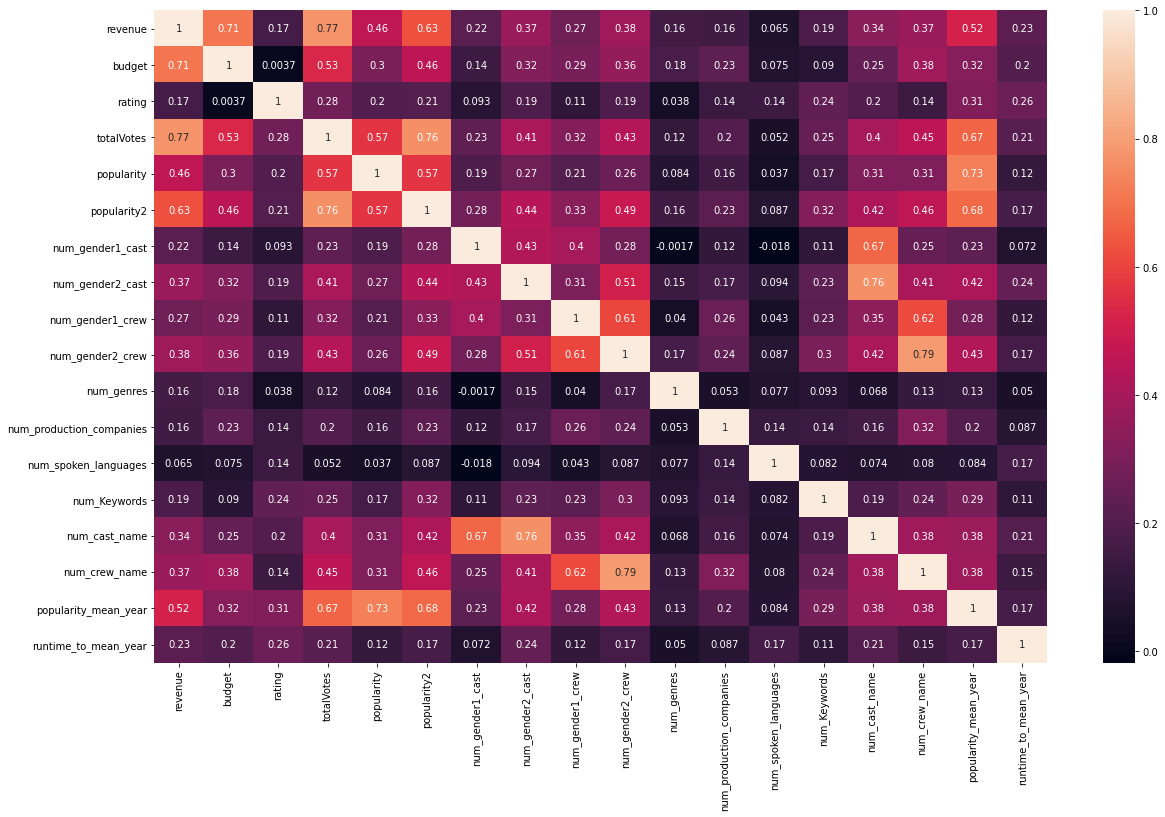

In [79]:
corr_matrix = train[['revenue','budget','rating','totalVotes','popularity','popularity2','num_gender1_cast','num_gender2_cast', 
                     'crew_name',  'num_gender1_crew','num_gender2_crew','num_genres','num_production_companies', 'num_spoken_languages', 'num_Keywords',
                     'num_cast_name', 'num_crew_name','popularity_mean_year','runtime_to_mean_year']]
f,ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corr_matrix.corr(), annot=True)
plt.show()

**Most positive correlation:** total votes & revenue, buget-to-mean-year & revenue<br>
**Most negative correlation:** num_spoken_languages & num_gender1_cast<br>
It is also interesting to see that *the number of female crew* has a relative high relation with *revenue, total votes* and *popularity*.

# Part 8 - Regression and Permutation Test

### Budget

In [80]:
X_train, X_test, y_train, y_test = train_test_split(np.log1p(train['budget']).values,train['log_revenue'])
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
reg = LinearRegression().fit(X_train, y_train)

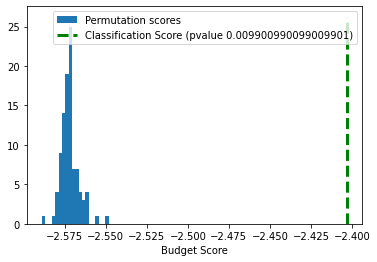

In [81]:
score, permutation_scores, pvalue = permutation_test_score(reg, X_test, y_test, scoring="neg_root_mean_squared_error", n_permutations=100)
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.vlines(score, ylim[0], ylim[1], linestyle='--',color='g', linewidth=3, label='Classification Score (pvalue %s)' % pvalue)
plt.legend()
plt.xlabel('Budget Score')
plt.show()

### Year

In [82]:
X_train, X_test, y_train, y_test = train_test_split(train['year'].values,train['log_revenue'])
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
reg = LinearRegression().fit(X_train, y_train)

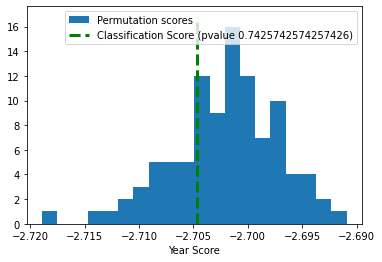

In [83]:
score, permutation_scores, pvalue = permutation_test_score(reg, X_test, y_test, scoring="neg_root_mean_squared_error", n_permutations=100)
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.vlines(score, ylim[0], ylim[1], linestyle='--',color='g', linewidth=3, label='Classification Score (pvalue %s)' % pvalue)
plt.legend()
plt.xlabel('Year Score')
plt.show()

### Total Votes

In [116]:
X_train, X_test, y_train, y_test = train_test_split(train['totalVotes'].values,train['log_revenue'])
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
reg = LinearRegression().fit(X_train, y_train)

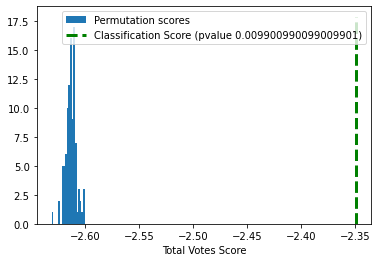

In [117]:
score, permutation_scores, pvalue = permutation_test_score(reg,X_test, y_test, scoring="neg_root_mean_squared_error", n_permutations=100)
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.vlines(2 *[score], ylim[0], ylim[1], linestyle='--',color='g', linewidth=3, label='Classification Score (pvalue %s)' % pvalue)
plt.legend()
plt.xlabel('Total Votes Score')
plt.show()

***Budget*** and ***Total Votes*** should have a relatively high relation with revenue, while ***year*** should not. <br>The permutation test plot proved this pattern.

# Part 9 - Predicton

In [91]:
## top 30 companies
list_all_companies = []
for x in list_companies:
  for i in range(len(x)):
    list_all_companies.append(x[i])
company_values, company_counts = np.unique(list_all_companies, return_counts=True)
company_count_pair = list(zip(company_values,company_counts))
company_count_pair.sort(key = lambda x: x[1],reverse=True)

top_30_companies = []
for p in company_count_pair[:30]:
  top_30_companies.append(p[0])


## top 15 countries
list_all_countries = []
for x in list_of_countries:
  for i in range(len(x)):
    list_all_countries.append(x[i])
country_values, country_counts = np.unique(list_all_countries, return_counts=True)
country_count_pair = list(zip(country_values,country_counts))
country_count_pair.sort(key = lambda x: x[1],reverse=True)

top_15_contries = []
for p in country_count_pair[:15]:
  top_15_contries.append(p[0])

#top 20 crew job
string_space = 'job'
train['crew_job'] = train['crew'].apply(extract_name)
test['crew_job'] = test['crew'].apply(extract_name)

list_all_crew_job = []
for x in train['crew_job']:
  for i in range(len(x)):
    list_all_crew_job.append(x[i])

crew_job_values, crew_job_counts = np.unique(list_all_crew_job, return_counts=True)
crew_job_count_pair = list(zip(crew_job_values,crew_job_counts))
crew_job_count_pair.sort(key = lambda x: x[1],reverse=True)

top_20_jobs = []
for p in crew_job_count_pair[:20]:
  top_20_jobs.append(p[0])

# top crew department
string_space = 'department'
train['crew_department'] = train['crew'].apply(extract_name)
test['crew_department'] = test['crew'].apply(extract_name)

list_all_crew_depart = []
for x in train['crew_department']:
  for i in range(len(x)):
    list_all_crew_depart.append(x[i])

crew_depart_values, crew_depart_counts = np.unique(list_all_crew_depart, return_counts=True)

#top original language
n_language = train.loc[:train.index[-1], "original_language"].value_counts()
large_language = n_language[n_language>=16].index
train.loc[~train["original_language"].isin(large_language), "original_language"] = "small"

top_orig_lang = list(large_language)
top_orig_lang.append('small')


In [92]:
# encoding 
for c in top_30_companies:
    train['prod_company_' + c] = train['production_companies'].apply(lambda x: 1 if c in x else 0)
    test['prod_company_' + c] = test['production_companies'].apply(lambda x: 1 if c in x else 0)

for c in top_15_contries:
    train['prod_country_' + c] = train['production_countries'].apply(lambda x: 1 if c in x else 0)
    test['prod_country_' + c] = test['production_countries'].apply(lambda x: 1 if c in x else 0)

for g in genres_values:
    train['genre_'+g] = train['genres'].apply(lambda x: 1 if g in x else 0)
    test['genre_'+g] = test['genres'].apply(lambda x: 1 if g in x else 0)

for j in top_20_jobs:
    train['job_'+j] = train['crew_job'].apply(lambda x: 1 if j in x else 0)
    test['job_'+j] = test['crew_job'].apply(lambda x: 1 if j in x else 0)

for l in top_orig_lang:
    train['orig_lang_'+l] = train['original_language'].apply(lambda x: 1 if l in x else 0)
    test['orig_lang_'+l] = test['original_language'].apply(lambda x: 1 if l in x else 0)

for d in crew_depart_values:
    train['depart_'+d] = train['crew_department'].apply(lambda x: 1 if d in x else 0)
    test['depart_'+d] = test['crew_department'].apply(lambda x: 1 if d in x else 0)


In [93]:
def prepare_df(df):
  df['budget_runtime_ratio']=df['budget']/df['runtime']
  df['budget_popularity_ratio']=df['budget']/df['popularity']
  df['budget_popularity2_ratio'] = df['budget']/df['popularity2']
  df['budget_year_ratio']=df['budget']/(df['year']*df['year'])
  df['popularity_totalVotes_ratio']=df['totalVotes']/df['popularity']
  df['rating_totalVotes_ratio']=df['totalVotes']/df['rating']
  df['totalVotes_releaseYear_ratio']=df['totalVotes']/df['year']
  df['budget_rating_ratio']=df['budget']/df['rating']
  df['budget_totalVotes_ratio']=df['budget']/df['totalVotes']
  return df

In [94]:
train = prepare_df(train)
test = prepare_df(test)
train.shape,test.shape

((3000, 183), (4398, 181))

In [102]:
train_use = train.drop(['id','belongs_to_collection','genres','homepage','imdb_id','original_language','original_title','overview','poster_path',
                     'production_companies','production_countries','release_date','weekday','cast_count', 'norm_cast_power','crew_job', 'crew_department','spoken_languages','status',
                     'tagline','title','Keywords','cast','cast_name','crew','crew_name','genre_TV Movie','depart_Actors',
                     'cast_power','log_cast_power','revenue','log_revenue'],axis=1)

test_use = test.drop(['id','belongs_to_collection','genres','homepage','imdb_id','original_language','original_title','overview','poster_path',
                     'production_companies','production_countries','release_date','weekday','cast_count','norm_cast_power', 'crew_job', 'crew_department','spoken_languages','status',
                     'tagline','title','Keywords','cast','cast_name','crew','crew_name','genre_TV Movie','depart_Actors',
                     'cast_power','log_cast_power'],axis=1)

In [103]:
train_use.shape,test_use.shape

((3000, 151), (4398, 151))

### Split the train data

In [104]:
trainy = train["log_revenue"]
X_train, X_test, y_train, y_test = train_test_split(train_use,trainy,test_size=0.3,random_state=100)

### XGboost Model

In [105]:
xgbmodel = xgb.XGBRegressor(max_depth=8, 
                            min_child_weight=3,
                            alpha = 0.5,
                            learning_rate=0.05, 
                            n_estimators=150, 
                            objective='reg:linear', 
                            gamma=0.01,  
                            silent=1,
                            subsample=0.8, 
                            colsample_bytree=0.8)

In [106]:
xgbmodel.fit(X_train, y_train)

XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=3, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.8, verbosity=1)

In [107]:
pred_train1 = xgbmodel.predict(X_train)
pred_test1 = xgbmodel.predict(X_test)

print(np.sqrt(mean_squared_error(y_train, pred_train1)))
print(np.sqrt(mean_squared_error(y_test, pred_test1)))

0.43939800007561897
1.5744937685248956


In [108]:
pred_xgb = xgbmodel.predict(test_use)
pred_xgb = pd.DataFrame(np.exp(pred_xgb)-1,columns=["revenue"])
pred_xgb.head()

,revenue
0,8.970780e+06
1,1.245184e+06
2,1.191645e+07
3,4.501956e+06
4,8.686692e+05


In [109]:
sub=pd.concat([test["id"], pred_xgb],axis=1)
sub.to_csv('xgb.csv',index=False)

### CATboost Model

In [110]:
catmodel = cat.CatBoostRegressor(iterations=2000, 
                                 learning_rate=0.01, 
                                 depth=8, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200)

In [ ]:
catmodel.fit(X_train, y_train)

In [112]:
pred_train3 = catmodel.predict(X_train)
pred_test3 = catmodel.predict(X_test)

print(np.sqrt(mean_squared_error(y_train, pred_train3)))
print(np.sqrt(mean_squared_error(y_test, pred_test3)))

0.6886609858234608
1.5410113246700483


In [113]:
pred_cat = catmodel.predict(test_use)
pred_cat = pd.DataFrame(np.exp(pred_cat)-1,columns=["revenue"])
pred_cat.head()

,revenue
0,7.025692e+06
1,1.876075e+06
2,1.226077e+07
3,5.374579e+06
4,8.207703e+05


In [114]:
sub2=pd.concat([test['id'], pred_cat],axis=1)
sub2.to_csv('cat.csv',index=False)

I first extract some more features that may help to predict. Then I split the test and train data, and use XGBboost and Catboost model to predict.
Since XGBoost doesn’t have an inbuilt method for categorical features, so I did one-hot encoding manually before fitting the model.<br>
As a result, the XGB model perform a little better than the Catboost model with a Kaggle score of 2.11139.

# Part 10 - Final Result

Report your highest score. Include a snapshot of your best score after submission as confirmation. Be sure to provide a link to your Kaggle profile. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/haruka03

Highest Score: 2.11139

Number of entries: 10

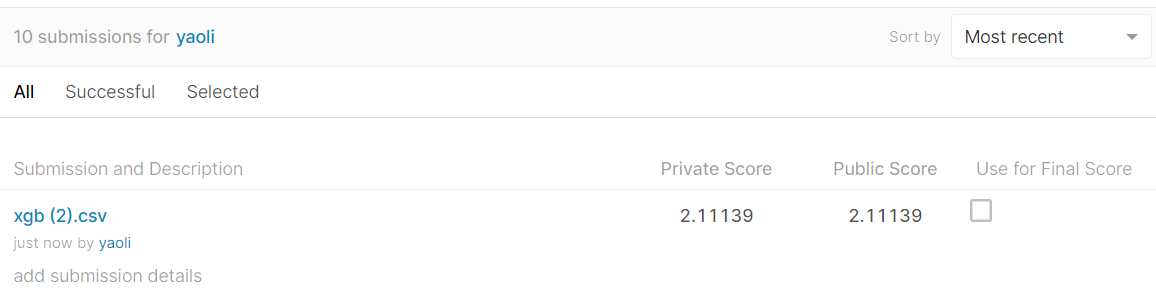